In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import plotting
plt.style.use(plotting.blueprint)
from IPython.display import display
from ipywidgets import interact
import scipy.spatial
import pandas as pd

# Gaussian processes

In the Wiener process introduced in the previous section the size of a random step is determined only by the length of time which the step takes.

What if we want to make a more complicated requirement on the data, so that the next step is determined by all of the previous steps? 

When we do this we get a Gaussian process, and the way in which steps must relate to the previous steps are determined by *covariance functions*.

## Covariance functions

In [4]:
def exp_q(x, y, length=1):
    """The squared-exponential covariance function"""
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    distances = scipy.spatial.distance.cdist(x, y, "sqeuclidean")
    return np.exp(-0.5 * 1./length * distances)

In [5]:
def exp(x, y, length=1):
    """The exponential covariance function"""
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    distances = scipy.spatial.distance.cdist(x, y, "euclidean")
    return np.exp(1./length * (distances))

In [6]:
def periodic(x, y, length=1, period=1):
    """The periodic covariance function"""
    distances = scipy.spatial.distance.cdist(np.expand_dims(x, 1), np.expand_dims(y, 1), "sqeuclidean")
    return np.exp(- (2*np.sin(np.pi*np.sqrt(distances/ length**2)/period)**2) )

In [7]:
def localperiodic(x, y, length1=1, length2=1, period=1):
    """The locally-periodic covariance function"""
    return(exp_q(x,y, length1) * periodic(x, y, length2, period))

In [8]:
x = np.linspace(-20, 20, 300)

In [107]:
class CovarianceFunction(object):
    """
    The base class for a covariance function.
    """
    def __init__(self, active_dimensions = "*", **kwargs):
        if not active_dimensions == "*":
            self.active_dimensions = active_dimensions
        else: 
            self.active_dimensions = None
            
        self.args = kwargs
            
    def distance(self, x, y):
        """
        Calculate the square euclidean distance between points in the active dimensions.
        """
        if self.active_dimensions:
            x = np.atleast_2d(x[self.active_dimensions])
            y = np.atleast_2d(y[self.active_dimensions])
        else:
            x = np.atleast_2d(x)
            y = np.atleast_2d(y)
            
        distances = scipy.spatial.distance.cdist(x, y, "sqeuclidean")
        
        return distances
    
    def __call__(self, x, y, **args):
        return self._evaluate(x, y, **args)

In [123]:
class ExponentialQuadratic(CovarianceFunction):
    def __init__(self, length=1, **parameters):
        super().__init__(**parameters)
        self.args['length'] = length
    
    def _evaluate(self, x, y, length = None):
        if not length:
            length = self.args['length']
        return np.exp(-0.5 * 1./length * self.distance(x, y))

In [126]:
cv1 = ExponentialQuadratic()
cv2 = ExponentialQuadratic()
cvs = [cv1, cv2]

In [136]:
results = np.linalg.multi_dot([cv(points, points) for cv in cvs])

In [137]:
results

array([[1.08470935e+00, 5.84006331e-01, 9.89962872e-02, 4.20050414e-03,
        6.00678131e-05, 2.15761166e-07, 2.61205039e-10, 7.94293402e-14,
        8.14061418e-18, 2.09567785e-22],
       [5.84006331e-01, 1.16936734e+00, 5.86091638e-01, 9.90006357e-02,
        4.20050490e-03, 6.00678132e-05, 2.15761166e-07, 2.61205039e-10,
        7.94293402e-14, 8.14061418e-18],
       [9.89962872e-02, 5.86091638e-01, 1.16941871e+00, 5.86091745e-01,
        9.90006357e-02, 4.20050490e-03, 6.00678132e-05, 2.15761166e-07,
        2.61205039e-10, 7.94293402e-14],
       [4.20050414e-03, 9.90006357e-02, 5.86091745e-01, 1.16941871e+00,
        5.86091745e-01, 9.90006357e-02, 4.20050490e-03, 6.00678132e-05,
        2.15761166e-07, 2.61205039e-10],
       [6.00678131e-05, 4.20050490e-03, 9.90006357e-02, 5.86091745e-01,
        1.16941871e+00, 5.86091745e-01, 9.90006357e-02, 4.20050490e-03,
        6.00678132e-05, 2.15761166e-07],
       [2.15761166e-07, 6.00678132e-05, 4.20050490e-03, 9.90006357e-02,
   

In [ ]:
class ProductCovariance(CovarianceFunction):
    def __init__(self):
        self.covariance_functions = []
        pass
    
    def __mul__(self, covariance_function):
        self.covariance_functions.append(covariance_function)
        
        
    def _evaluate(self, x, y, **args):
        

In [109]:
points = pd.DataFrame({"lats": np.linspace(0,10,10),
                       "lons": np.linspace(80,90,10)
                      })

In [114]:
class GaussianProcess(object):
    """
    A simple implementation of a Gaussian process.
    """
    
    def __init__(self, covariance, **parameters):
        """
        Parameters
        ----------
        covariance : function
            The covariance function to use for the GP.
        """
        self.covariance_function = covariance(**parameters)
        self.covariance_parameters = parameters

        self.x_columns = ["x"]
        self.y_columns = ["y"]
        self.y_error_columns = [col+"_err" for col in self.y_columns]
        self.data = pd.DataFrame(columns=["x", "y"])
        
    def __call__(self, x, samples=0, **kwargs):
        """
        Evaluate the Gaussian process, and return the mean 
        and variance, and potentially some samples.
        
        Parameters
        ----------
        x : np.array
            The locations at which the GP should be evaluated.
        samples : int, optional
            The number of samples to draw from the GP
            Defaults to 0, in which case no samples are returned.
        """
        mean, var = self.evaluate(x)
        if samples > 0:
            samples = self.samples(x, realisations=samples, **kwargs)
            return mean, var, samples
        else:
            return mean, var
        
    def _invert(self, matrix):
        return np.linalg.inv(matrix)
        
    def _compute(self, x):
        """
        Compute the covariance matrices.
        
        Parameters
        ----------
        x : np.array
            The locations at which the GP should be evaluated.
        """
        x = np.atleast_2d(x)
        # Check if there is any conditioning data. If there is, calculate the appropriate matrices.
        if len(self.data)>0:
            x_data = np.atleast_2d(self.data[self.x_columns])
            
            self.Kdata = self.covariance_function(x_data, x_data, **self.covariance_parameters)
            self.error_matrix = np.identity(len(x_data)) * np.array(self.data[self.y_error_columns]**2)
            
            self.Kdata_inv = self._invert(self.Kdata + self.error_matrix)
            
            self.Kdata_new = self.covariance_function(x_data, x.T, **self.covariance_parameters)
        else:
            self.Kdata_inv = np.array([])
            self.Kdata_new = np.array([])
        self.Knew_new = self.covariance_function(x.T, x.T, **self.covariance_parameters)
        
    def _data(self, data, x_columns, y_columns):
        
        self.x_columns = x_columns
        self.y_columns = y_columns
        self.data = data
        
    def evaluate(self, x):
        """
        Evaluate the Gaussian process.
        
        Parameters
        ----------
        x : np.array
            The locations at which the GP should be evaluated.
            
        See also
        ---------
        self.__call__
        """
        self._compute(x)
        means = {}
        var = {}
        for y_column in self.y_columns:
            if len(self.Kdata_new) == 0:
                means[y_column] = np.zeros(x.shape[0])
            else:
                means[y_column] = np.dot(np.dot(self.Kdata_new.T, self.Kdata_inv), self.data[y_column])
            if len(self.Kdata_new) == 0:
                var[y_column] = self.Knew_new
            else:        
                var[y_column] = self.Knew_new - np.dot(np.dot(self.Kdata_new.T, self.Kdata_inv), self.Kdata_new)
            
        return means, var
    
    def samples(self, x, realisations = 10, continuous=False, alpha=0.1, mstep=5, tstep=0.1):
        
        means, var = self.evaluate(x)
        
        p = []
        z = []
        
        samples = {}
        for y_column in self.y_columns:
            
            if continuous:
                steps = realisations
                for step in range(steps):
                    if step == 0:
                        initial = np.random.multivariate_normal(mean = means[y_column], cov=var[y_column])
                        z.append(initial)
                        p.append(initial)
                    if step % mstep == 0:
                        new_state = alpha*p[-1] + (np.sqrt(1-alpha**2) * np.random.multivariate_normal(mean = means[y_column], cov=var[y_column]))
                        z.append(z[-1])
                        p.append(new_state)
                    else:
                        a = z[-1]
                        b = p[-1] 
                        c = -1 * z[-1]
                        d = p[-1]

                        z.append((a * np.sin(tstep)) + (b * np.cos(tstep)))
                        p.append((c * np.sin(tstep)) + (d * np.cos(tstep)))

                samples[y_column] = (means[y_column] + np.array(z))[1:,:].T
            else:
                samples[y_column] = np.random.multivariate_normal(mean = means[y_column], cov=var[y_column], size=realisations).T
            
        return samples
    
    def plot(self, x, realisations = 10, ax=None, continuous_samples=True, lw=2):
        if not ax:
            f, ax = plt.subplots(1,1, dpi=300)
        means, var = self.evaluate(x)
       
        ax.plot(x, self.samples(x, realisations, continuous=continuous_samples)[self.y_columns[0]], lw=lw)
        ax.plot(x, means[self.y_columns[0]], color='yellow', lw=lw+1)
        ax.plot(x, means[self.y_columns[0]] + np.diag(var[self.y_columns[0]]), color='yellow', lw=lw, linestyle="--")
        ax.plot(x, means[self.y_columns[0]] - np.diag(var[self.y_columns[0]]), color='yellow', lw=lw, linestyle="--")

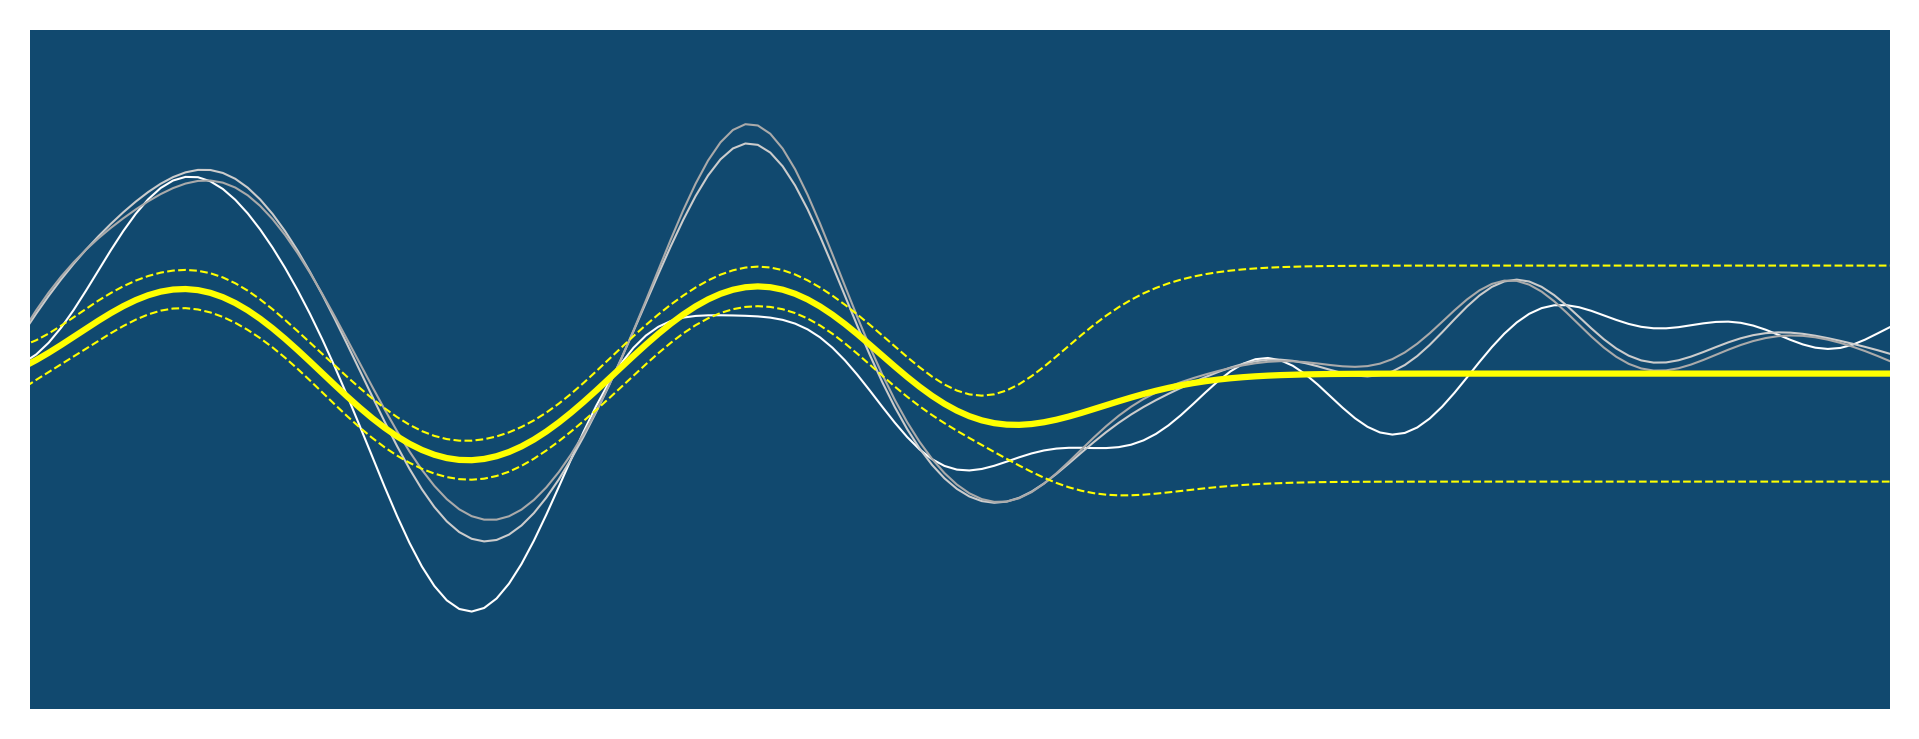

In [117]:
gp = GaussianProcess(ExponentialQuadratic, length=1.5)

f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)


data = pd.DataFrame({"x": np.linspace(0, 10, 8),
                     "y": np.sin(np.linspace(0, 10, 8)),
                     "y_err": .5 * np.ones(8)
                    })
gp._data(data, ["x"], ["y"])

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

gp.plot(x, lw=0.5, continuous_samples=True, realisations=3, ax=ax)

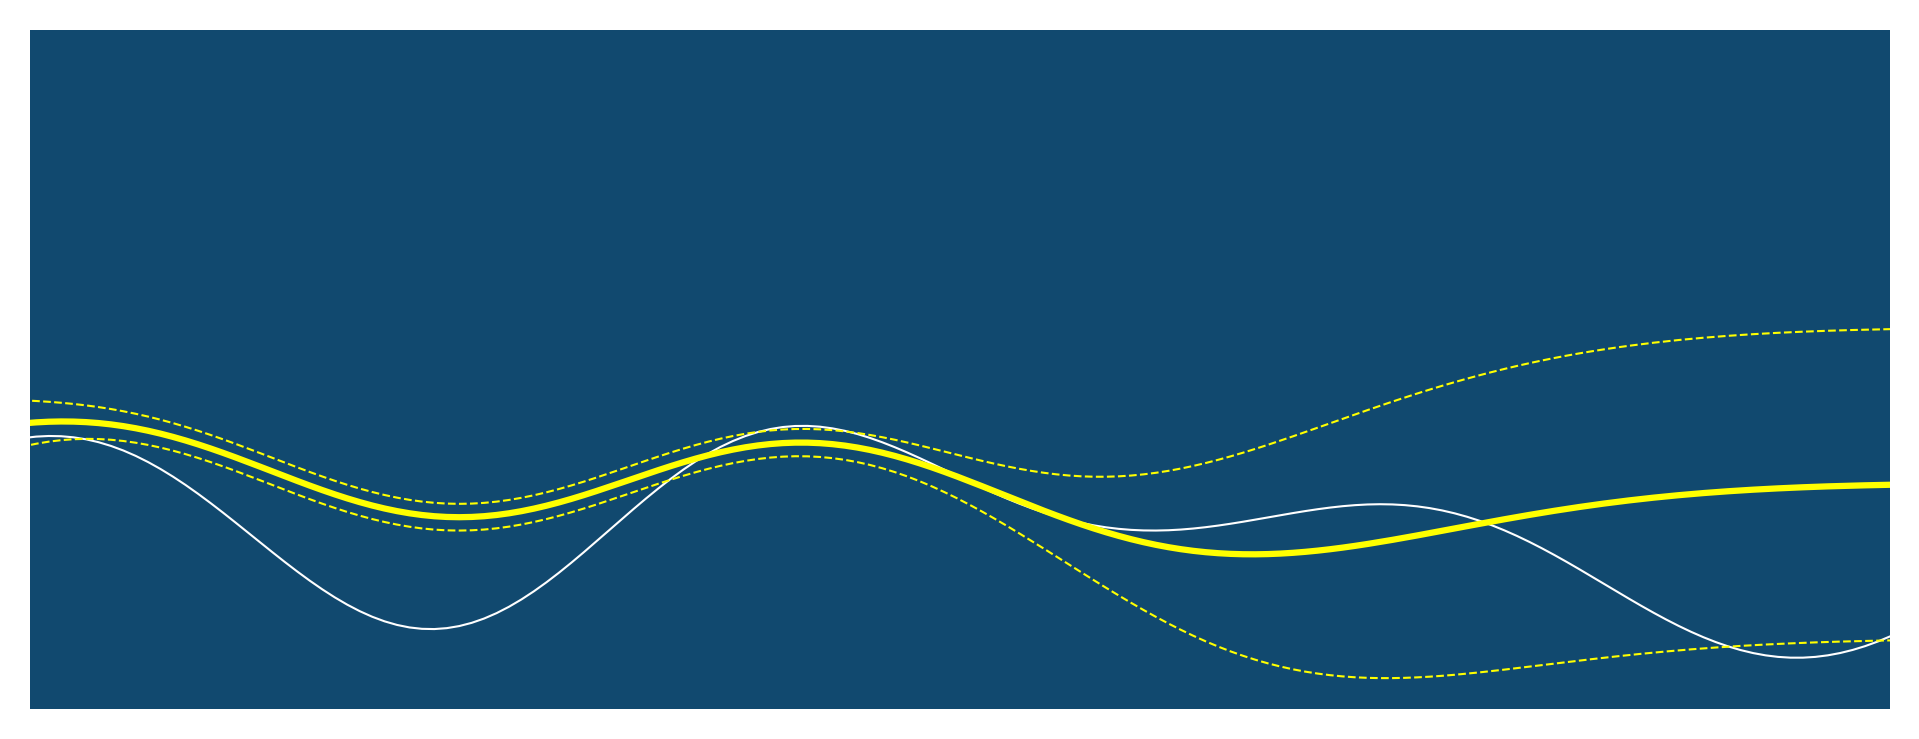

In [188]:
gp = GaussianProcess(exp_q, length=10)

f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)


data = pd.DataFrame({"x": np.linspace(0, 10, 8),
                     "y": np.sin(np.linspace(0, 10, 8)),
                     "y_err": 0.5 * np.ones(8)
                    })
gp._data(data, ["x"], ["y"])

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

gp.plot(x, lw=0.5, continuous_samples=True, realisations=1, ax=ax)

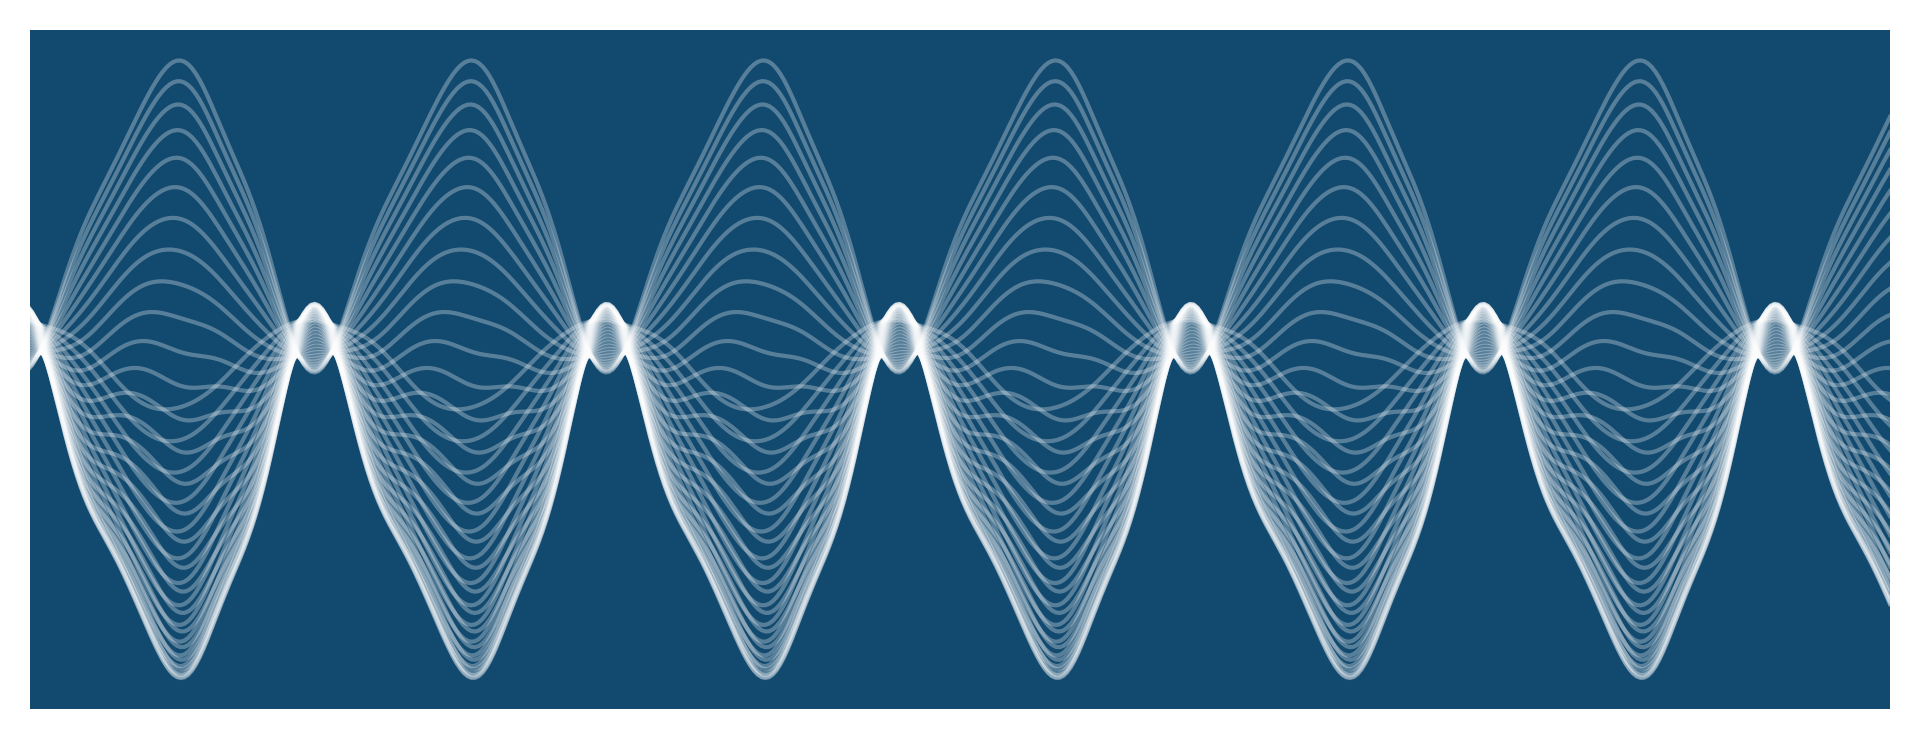

In [70]:
f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)

ax.plot(x, gp_prior_samples(x, periodic, realisations=40, length=1.5, period=np.pi).T[:,1:], color='w', lw =1, alpha=0.3);
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
f.savefig("../gpr-cover2.png")

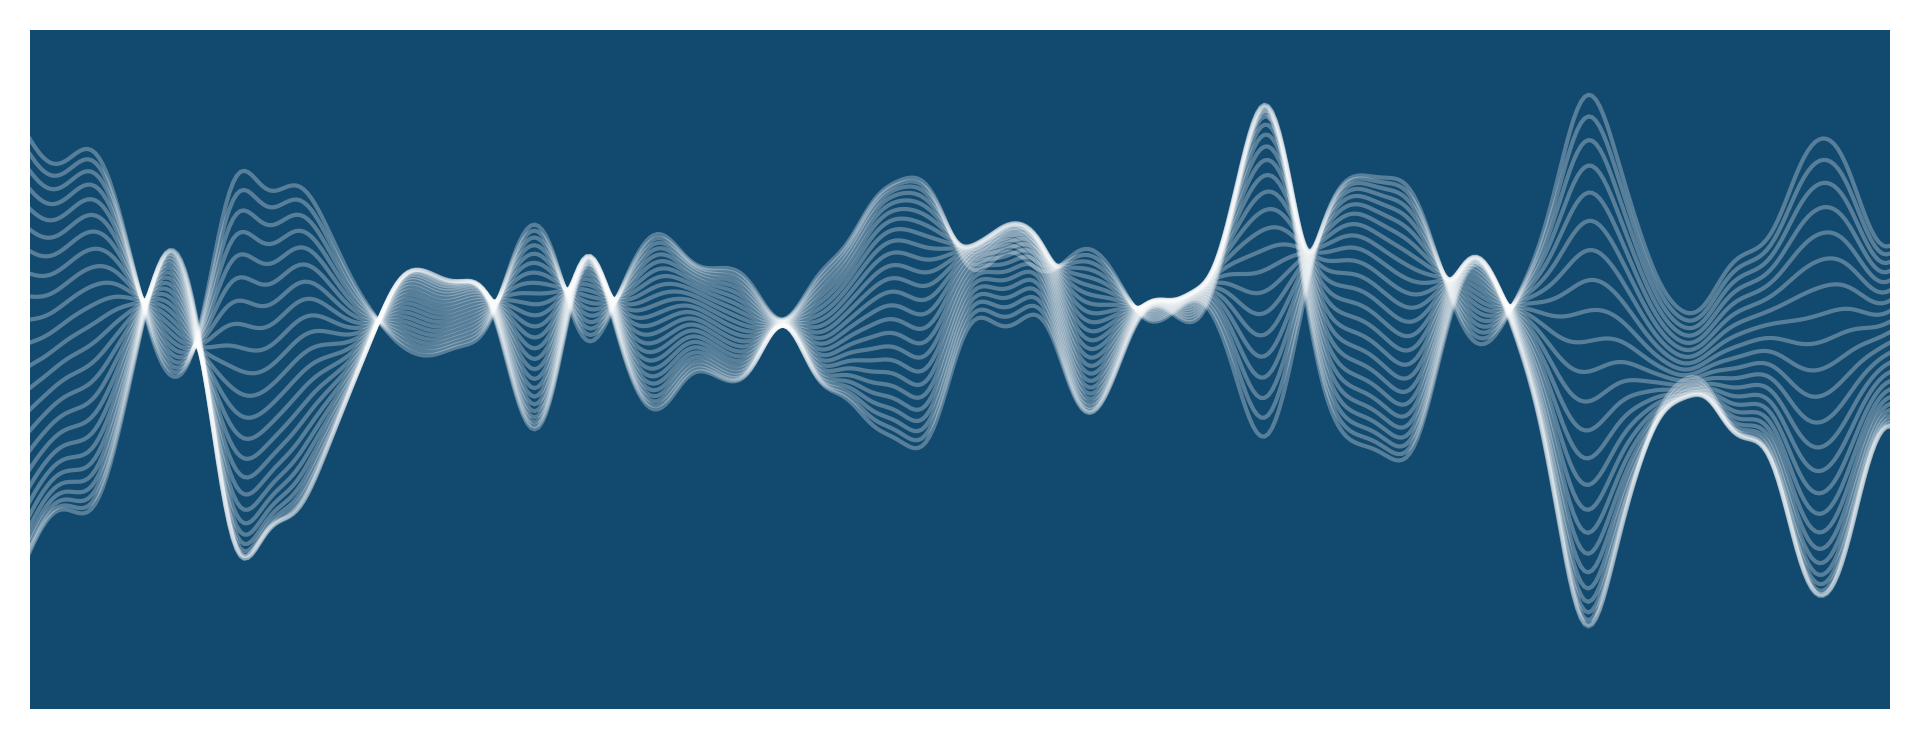

In [71]:
f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)

ax.plot(x, gp_prior_samples(x, localperiodic, realisations=25, length1=1.5, period=np.pi).T[:,1:], color='w', lw =1, alpha=0.3);
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
f.savefig("../gpr-cover3.png")

In [40]:
def gp_posterior_samples(x, data_x, data_y, covariance_function, 
                         realisations=1, alpha=0.2, tstep=0.1, mstep=50, **covariance_pars):

    Kdata = covariance_function(data_x, data_x, **covariance_pars)
    Kdata_inv = np.linalg.inv(Kdata)
    np.dot(Kdata_inv, data_y)
    Kdata_new = covariance_function(data_x, x, **covariance_pars)
    #print(np.dot(Kdata_new.T, Kdata_inv).shape)
    Knew_new = covariance_function(x, x, **covariance_pars)
    mean = np.dot(np.dot(Kdata_new.T, Kdata_inv), data_y)
    variance = Knew_new - np.dot(np.dot(Kdata_new.T, Kdata_inv), Kdata_new)
    
    p = []
    z = []
    
    steps = realisations
    for step in range(steps):
        if step == 0:
            initial = np.random.multivariate_normal(mean = 0.*np.ones(variance.shape[0]), cov=variance)
            z.append(initial)
            p.append(initial)
        if step % mstep == 0:
            new_state = alpha*p[-1] + (np.sqrt(1-alpha**2) * np.random.multivariate_normal(mean = 0.*np.ones(variance.shape[0]), cov=variance))
            z.append(z[-1])
            p.append(new_state)
        else:
            a = z[-1]
            b = p[-1] 
            c = -1 * z[-1]
            d = p[-1]
            
            z.append((a * np.sin(tstep)) + (b * np.cos(tstep)))
            #outs.append(alpha * outs[-1] + np.sqrt(1-alpha**2) * np.random.multivariate_normal(mean = 0.4*np.ones(K.shape[0]), cov=K))
            p.append((c * np.sin(tstep)) + (d * np.cos(tstep)))

    return  mean + np.array(z)

In [47]:
xdata = np.linspace(0, 20, 7)
ydata = np.sin(xdata)

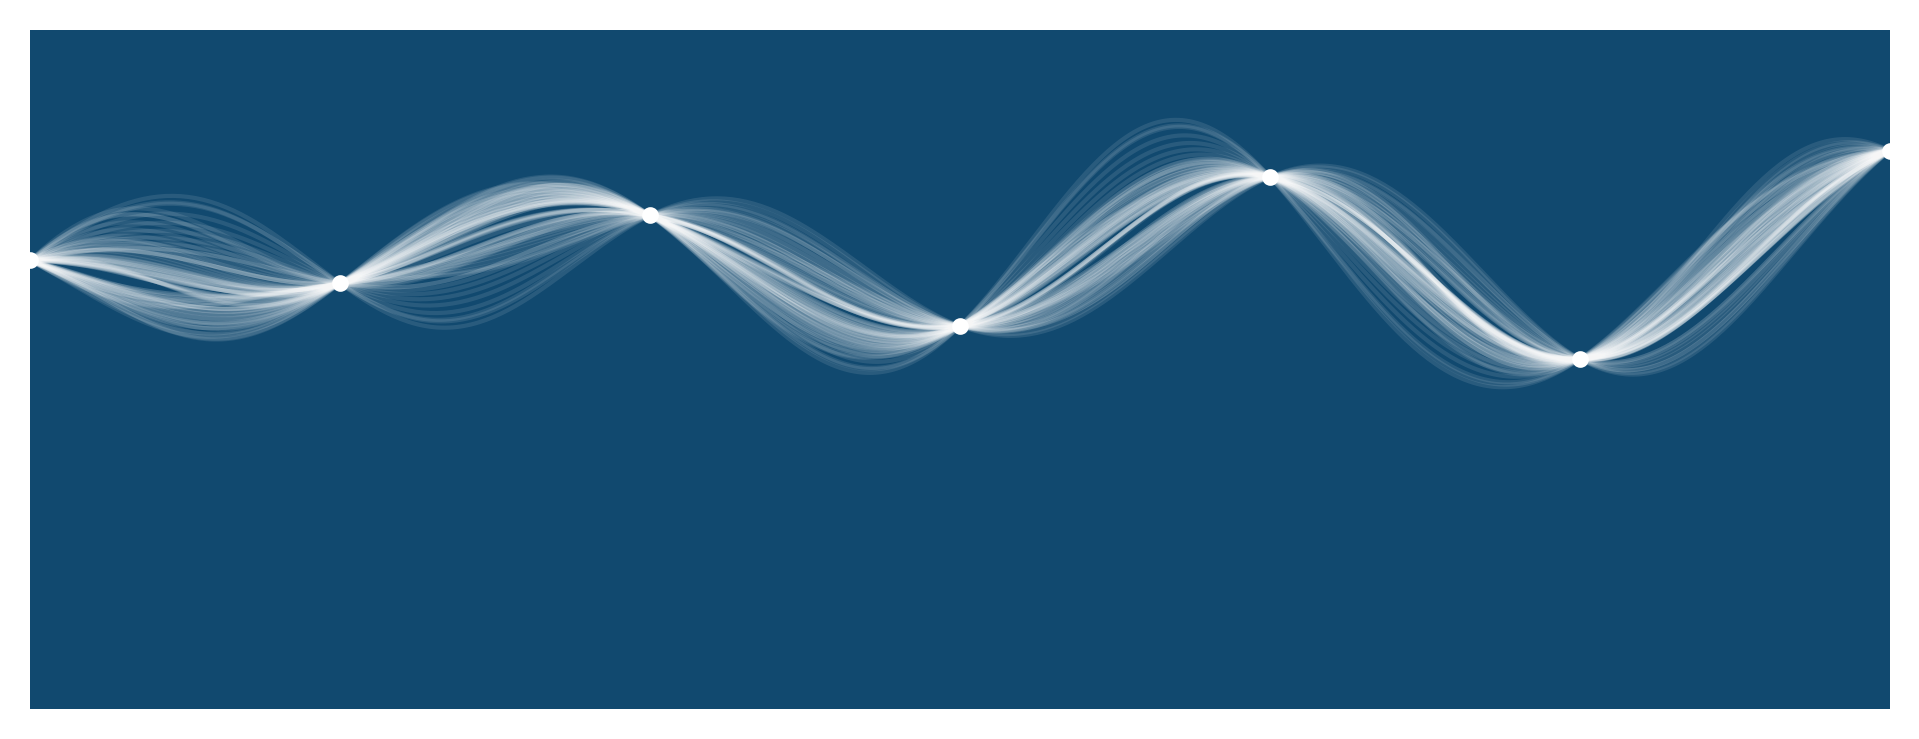

In [72]:
f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)
samples = gp_posterior_samples(x, xdata, ydata, exp_q, 
                                 realisations=100, alpha=0.5, length=5, tstep=.1, mstep=10).T
ax.plot(x, samples, color='w', lw=1, alpha=0.1);
ax.plot(xdata, ydata, '.')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
f.savefig("../gpr-cover4.png")

/home/daniel/.virtualenvs/IGRlaptop21/teaching-stats/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.
/home/daniel/.virtualenvs/IGRlaptop21/teaching-stats/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: covariance is not positive-semidefinite.


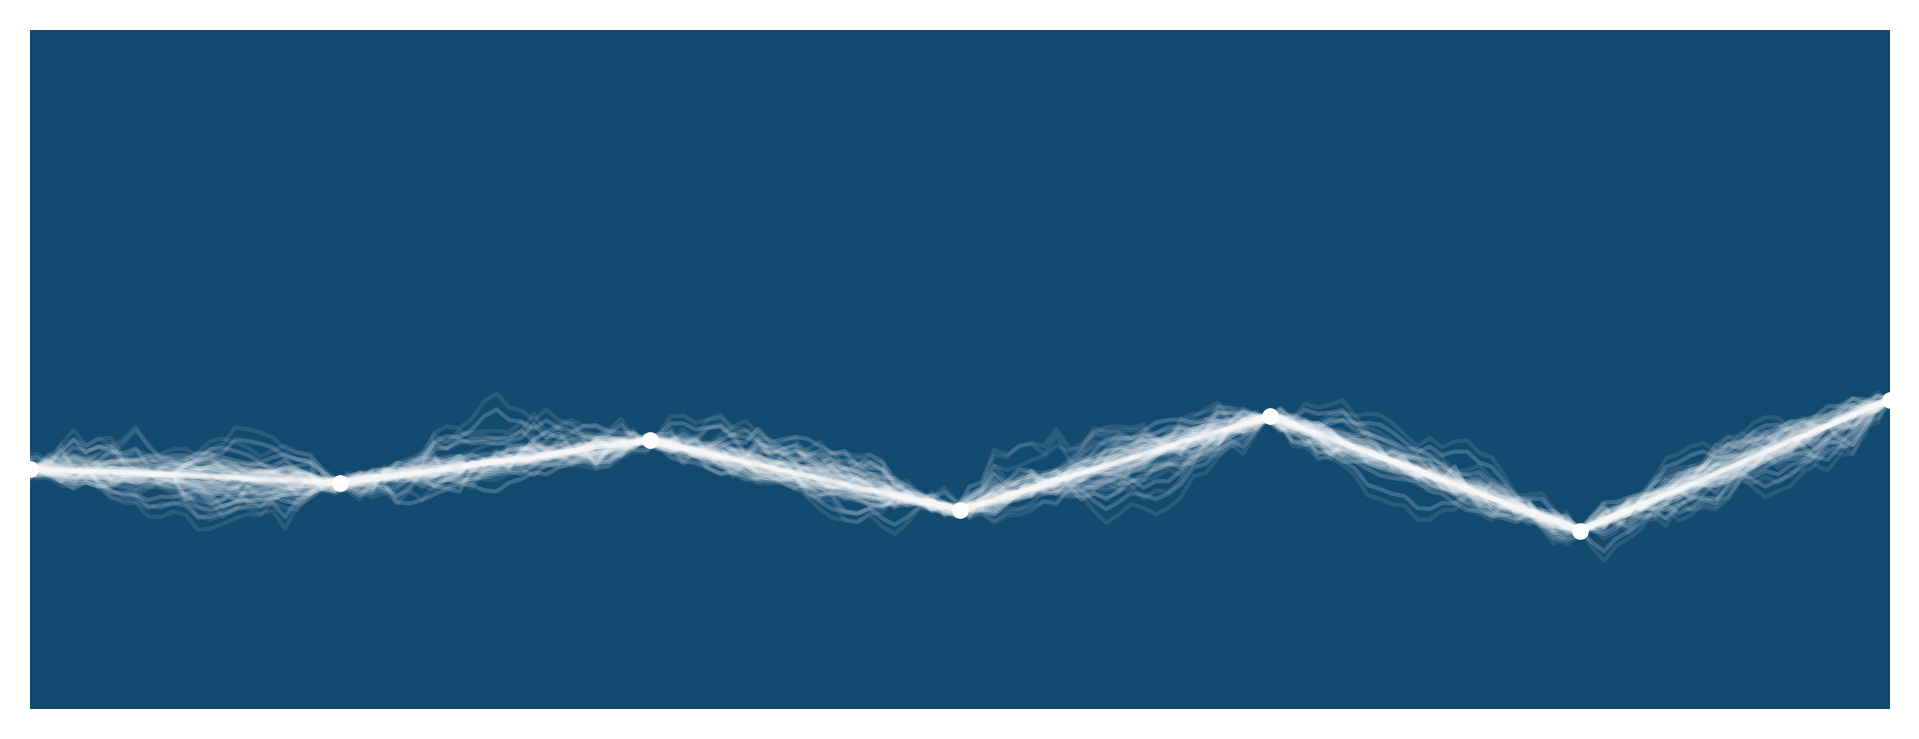

In [60]:
f, ax = plt.subplots(1,1, figsize=(8,3), dpi=300)
samples = gp_posterior_samples(x, xdata, ydata, exp, 
                                 realisations=100, alpha=0.5, length=19.1, tstep=.4, mstep=10).T
ax.plot(x, samples, color='w', lw=1, alpha=0.1);
ax.plot(xdata, ydata, '.')

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [62]:
from matplotlib.animation import FuncAnimation

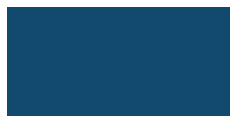

In [145]:
from IPython.display import HTML

f, ax = plt.subplots(1,1, figsize=(4,2))
x = np.linspace(0, 20, 100)

ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-0,20]);
ax.set_ylim([-5,5]);
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)

samples = []
xs = []
ys = []

for points in range(20):
    xdata = np.linspace(0, points, points)
    ydata = np.sin(xdata)
    xs.append(xdata)
    ys.append(ydata)
    samples.append(gp_posterior_samples(x, xdata, ydata, exp_q, realisations=30, length=2, tstep=0.5, mstep=5).T)

In [146]:
samples = np.hstack(samples)

In [147]:
samples.shape

(100, 620)

In [148]:
line, = ax.plot([], [], lw=1)
points, = ax.plot([], [], '.', c='w')

#ax.plot(xdata, ydata, '.', c='k')

def init():
    line.set_data([], [])
    points.set_data([], [])
    return line,
def animate(i):
    y = samples[:, i]
    points.set_data(xs[int(np.floor(i/30))], ys[int(np.floor(i/30))])
    line.set_data(x, y)
    return line,
anim = FuncAnimation(f, animate, init_func=init,
                               frames=600, interval=30, blit=True)
HTML(anim.to_html5_video())